<a href="https://colab.research.google.com/github/raveheart1/ScoreSage/blob/main/epl-confusion-matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
# installing dependencies
import pandas as pd
try:
    from catboost import CatBoostClassifier
except ModuleNotFoundError:
    !pip install catboost
    from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [73]:
data = pd.read_csv("/content/premier-league-matches.csv")

In [74]:
data['result'] = data.apply(lambda row: 'win' if row['HomeGoals'] > row['AwayGoals'] else ('lose' if row['HomeGoals'] < row['AwayGoals'] else 'draw'), axis=1)

In [75]:
data = data.drop(columns=['HomeGoals', 'AwayGoals'])

In [76]:
data['home_team'] = data['Home'].astype('category').cat.codes
data['away_team'] = data['Away'].astype('category').cat.codes

In [77]:
# Create 'home_win' and 'away_win' indicators
data['home_win'] = data['result'].apply(lambda x: 1 if x == 'win' else 0)
data['away_win'] = data['result'].apply(lambda x: 1 if x == 'lose' else 0)

# Calculate recent form for the last 5 games for both teams using transform
data['home_team_form'] = data.groupby('home_team')['home_win'].transform(
    lambda x: x.shift().rolling(5).sum()
).fillna(0)

data['away_team_form'] = data.groupby('away_team')['away_win'].transform(
    lambda x: x.shift().rolling(5).sum()
).fillna(0)



In [78]:
# Convert 'result' to numeric codes for goal difference
result_mapping = {'win': 1, 'draw': 0, 'lose': -1}
data['numeric_result'] = data['result'].map(result_mapping)

In [79]:
# Calculate the expanding mean of goal differences using transform
data['home_team_avg_gd'] = data.groupby('home_team')['numeric_result'].transform(
    lambda x: x.shift().expanding().mean()
).fillna(0)

data['away_team_avg_gd'] = data.groupby('away_team')['numeric_result'].transform(
    lambda x: x.shift().expanding().mean()
).fillna(0)

In [80]:
# Home vs Away Fixture Indicator
data['is_home_game'] = 1

In [81]:
# Head-to-Head Statistics Feature
data['h2h_record'] = data.apply(
    lambda row: len(data[
        (data['home_team'] == row['home_team']) &
        (data['away_team'] == row['away_team']) &
        (data.index < row.name)  # Only count past matches
    ]),
    axis=1
)

In [82]:
data = data.drop(columns=['home_win', 'away_win', 'numeric_result'])

In [83]:
y = data['result']  # This should contain 'win', 'lose', 'draw'

In [84]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Classes in label_encoder:")
print(label_encoder.classes_)
print("Data type of classes:", type(label_encoder.classes_[0]))

print("First few entries of y:")
print(y.head())
print("Data type of y elements:", type(y.iloc[0]))


Classes in label_encoder:
['draw' 'lose' 'win']
Data type of classes: <class 'str'>
First few entries of y:
0     win
1     win
2     win
3    draw
4    lose
Name: result, dtype: object
Data type of y elements: <class 'str'>


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    verbose=100,
    random_seed=42
)

In [87]:
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True,
    early_stopping_rounds=50
)

0:	learn: 0.4610187	test: 0.4642560	best: 0.4642560 (0)	total: 5.88ms	remaining: 5.87s
100:	learn: 0.5044699	test: 0.5128845	best: 0.5128845 (93)	total: 415ms	remaining: 3.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5162094763
bestIteration = 139

Shrink model to first 140 iterations.


In [88]:
y_pred = model.predict(X_test)

In [90]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.52
Classification Report:
              precision    recall  f1-score   support

        draw       0.38      0.01      0.01       596
        lose       0.52      0.38      0.44       700
         win       0.52      0.88      0.65      1110

    accuracy                           0.52      2406
   macro avg       0.47      0.42      0.37      2406
weighted avg       0.48      0.52      0.43      2406



Accuracy: 0.52
Classification Report:
              precision    recall  f1-score   support

        draw       0.38      0.01      0.01       596
        lose       0.52      0.38      0.44       700
         win       0.52      0.88      0.65      1110

    accuracy                           0.52      2406
   macro avg       0.47      0.42      0.37      2406
weighted avg       0.48      0.52      0.43      2406



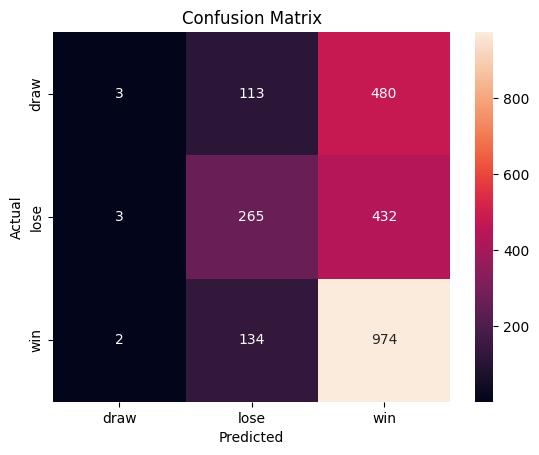

In [91]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Display the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()